## Import libaries

In [1]:
# !pip uninstall dea_ml -y
# !pip install -e dea_ml
# !pip install git+https://github.com/digitalearthafrica/deafrica-sandbox-notebooks.git@minty-fresh-sandbox#subdirectory=Tools

In [2]:
import warnings
warnings.filterwarnings("ignore")

import json
import joblib
import fsspec
from odc.io.cgroups import get_cpu_quota

from dea_ml.core.feature_layer import create_features, get_xy_from_task
from dea_ml.helpers.json_to_taskstr import extract_taskstr_from_geojson
from dea_ml.helpers.io import download_file
from dea_ml.core.africa_geobox import AfricaGeobox
from dea_ml.core.predict_from_feature import PredictContext, predict_with_model
from dea_ml.config.product_feature_config import FeaturePathConfig

%load_ext autoreload
%autoreload 2 

## Analysis Params


In [3]:
# define the feature layer fucntion
from gm_mads_two_seasons import gm_mads_two_seasons
feature_layer_function = gm_mads_two_seasons 

#define the post_processing function
from post_processing import post_processing
post_process = post_processing

tiles_geojson = '../testing/eastern_cropmask/data/s2_tiles_eastern_aez.geojson'

model_path = '../testing/eastern_cropmask/results/gm_mads_two_seasons_ml_model_20210401.joblib'

#define the chunks to use for dask
dask_chunks = {'x': 5000, 'y':5000}


## Initiate configuration class

In [4]:
# import the configuration
config = FeaturePathConfig
config

dea_ml.config.product_feature_config.FeaturePathConfig

## Open tiles and model

In [5]:
config.tiles_geojson = tiles_geojson

tile_geojson_url= config.tiles_geojson 

with fsspec.open(tile_geojson_url) as fh:
    tiles_geojson_dict = json.load(fh)

In [6]:
# Open model
config.model_path = model_path
ml_model_url = config.model_path

with fsspec.open(ml_model_url) as fh:
    model = joblib.load(fh)
model.n_jobs = round(get_cpu_quota()) #update model with cpus available on this machine
print(model)

RandomForestClassifier(max_features='log2', n_estimators=300, n_jobs=15,
                       random_state=1)


## Generate 'tasks' based on tiles


In [7]:
tasks = extract_taskstr_from_geojson(time_range='2019-01--P6M', geojson=tiles_geojson_dict)
len(tasks)

390

## Generate features for model


First generate a dictionary of geobox's for each tile

In [8]:
x, y = get_xy_from_task(tasks[0])

#update tile id
x = x+181
y = y+77
print(x,y)

geobox_dict = AfricaGeobox().geobox_dict

210 77


Pass the feature layer function into the `create_features` function

**Note:** This will take a couple of minutes to run.


In [9]:
%%time
subfld, geobox, data = create_features(x,
                                       y,
                                       config,
                                       geobox_dict,
                                       feature_func=gm_mads_two_seasons,
                                       dask_chunks=dask_chunks) 

print(data)

<xarray.Dataset>
Dimensions:        (x: 9600, y: 9600)
Coordinates:
    time           datetime64[ns] 2019-04-01T11:59:59.999999
  * y              (y) float64 9.6e+04 9.598e+04 9.598e+04 ... 25.0 15.0 5.0
  * x              (x) float64 2.784e+06 2.784e+06 ... 2.88e+06 2.88e+06
    spatial_ref    int32 6933
    band           int64 1
Data variables:
    blue_S1        (y, x) float32 dask.array<chunksize=(5000, 5000), meta=np.ndarray>
    green_S1       (y, x) float32 dask.array<chunksize=(5000, 5000), meta=np.ndarray>
    red_S1         (y, x) float32 dask.array<chunksize=(5000, 5000), meta=np.ndarray>
    nir_S1         (y, x) float32 dask.array<chunksize=(5000, 5000), meta=np.ndarray>
    swir_1_S1      (y, x) float32 dask.array<chunksize=(5000, 5000), meta=np.ndarray>
    swir_2_S1      (y, x) float32 dask.array<chunksize=(5000, 5000), meta=np.ndarray>
    red_edge_1_S1  (y, x) float32 dask.array<chunksize=(5000, 5000), meta=np.ndarray>
    red_edge_2_S1  (y, x) float32 dask.array<c

## Run prediction

**Note:** This will take a couple of minutes to run as the calculations are computed and brought into memory

In [10]:
pff = PredictContext(config, geobox_dict)
pff.client

Client Scheduler: inproc://10.85.104.113/22104/1 Dashboard: /user/chad/proxy/8787/status,Cluster Workers: 1 Cores: 15 Memory: 96.64 GB


In [11]:
%%time
predicted = predict_with_model(config,model,data).compute()
print(predicted)

predicting...
   probabilities...
   input features...


distributed.comm.inproc - WARNING - Closing dangling queue in <InProc  local=inproc://10.85.104.113/22104/1 remote=inproc://10.85.104.113/22104/10>


<xarray.Dataset>
Dimensions:        (x: 9600, y: 9600)
Coordinates:
  * x              (x) float64 2.784e+06 2.784e+06 ... 2.88e+06 2.88e+06
  * y              (y) float64 9.6e+04 9.598e+04 9.598e+04 ... 25.0 15.0 5.0
    spatial_ref    int32 0
Data variables:
    Predictions    (y, x) int8 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    Probabilities  (y, x) float32 73.333336 73.666664 74.0 ... 71.666664 70.0
    red_S1         (y, x) float32 0.0387 0.039 0.0376 ... 0.084 0.0815 0.0844
    blue_S1        (y, x) float32 0.0418 0.0411 0.04 ... 0.0591 0.0582 0.0603
    green_S1       (y, x) float32 0.0531 0.054 0.0524 ... 0.0794 0.0795 0.0799
    nir_S1         (y, x) float32 0.2399 0.2502 0.2529 ... 0.2287 0.2583 0.2404
    swir_1_S1      (y, x) float32 0.1338 0.1349 0.1351 ... 0.2272 0.2289 0.2275
    swir_2_S1      (y, x) float32 0.0621 0.0625 0.0623 ... 0.1599 0.1575 0.1626
    red_edge_1_S1  (y, x) float32 0.0763 0.0772 0.077 ... 0.1205 0.1232 0.1291
    red_edge_2_S1  (y, x) 

## Post processing

In [12]:
%%time
predict, proba, filtered = post_process(data, predicted, config, geobox)

[2021-04-16 04:16:39,661] {env.py:433} WARNING - CPLE_NotSupported in driver GTiff does not support creation option WIDTH
[2021-04-16 04:16:39,662] {env.py:433} WARNING - CPLE_NotSupported in driver GTiff does not support creation option HEIGHT
[2021-04-16 04:16:39,662] {env.py:433} WARNING - CPLE_NotSupported in driver GTiff does not support creation option COUNT
[2021-04-16 04:16:39,663] {env.py:433} WARNING - CPLE_NotSupported in driver GTiff does not support creation option DTYPE
[2021-04-16 04:16:39,664] {env.py:433} WARNING - CPLE_NotSupported in driver GTiff does not support creation option CRS
[2021-04-16 04:16:39,665] {env.py:433} WARNING - CPLE_NotSupported in driver GTiff does not support creation option TRANSFORM
   image segmentation...
   calculating mode...
     post processing
CPU times: user 9min 26s, sys: 16 s, total: 9min 42s
Wall time: 9min 44s


## save data
- result will be in: 
```/home/jovyan/wa/u23/data/crop_mask_eastern/v0.1.7/x+029/y+000/2019```

In [13]:
pff.save_data(subfld, predict, proba, filtered, geobox)

[2021-04-16 04:26:10,953] {predict_from_feature.py:101} INFO - collecting mask and write cog.
[2021-04-16 04:26:11,304] {env.py:433} WARNING - CPLE_NotSupported in driver GTiff does not support creation option WIDTH
[2021-04-16 04:26:11,305] {env.py:433} WARNING - CPLE_NotSupported in driver GTiff does not support creation option HEIGHT
[2021-04-16 04:26:11,306] {env.py:433} WARNING - CPLE_NotSupported in driver GTiff does not support creation option COUNT
[2021-04-16 04:26:11,307] {env.py:433} WARNING - CPLE_NotSupported in driver GTiff does not support creation option DTYPE
[2021-04-16 04:26:11,308] {env.py:433} WARNING - CPLE_NotSupported in driver GTiff does not support creation option CRS
[2021-04-16 04:26:11,309] {env.py:433} WARNING - CPLE_NotSupported in driver GTiff does not support creation option TRANSFORM
[2021-04-16 04:26:14,469] {predict_from_feature.py:108} INFO - collecting prob and write cog.
[2021-04-16 04:26:15,220] {env.py:433} WARNING - CPLE_NotSupported in driver 

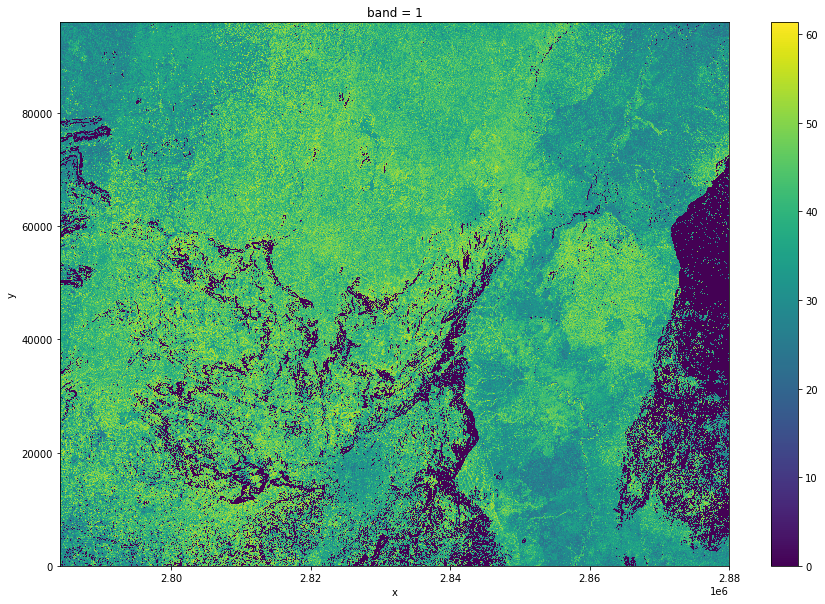

In [17]:
import xarray as xr
xr.open_rasterio('/g/data/crop_mask_eastern_data/crop_mask_eastern/v0.1.8/x210/y077/2019/crop_mask_eastern_x210_y077_2019_prob.tif').plot(size=10)

In [ ]:
# !ls /home/jovyan/wa/u23/data/crop_mask_eastern/v0.1.7/x+029/y+000/2019